In [2]:
import sys
import os
sys.path.append('..')

In [ ]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Solutions
from library.solution import Solution
from library.custom.custom_solutions import WSOSolution, WSOGASolution
from library.data.relationship_matrix import relationship_matrix

# Operators
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm
from library.algorithms.genetic_algorithms.selection import fitness_proportionate_selection
from library.custom.custom_crossover import cycle_crossover, partially_matched_crossover, pos_based_crossover
from library.custom.custom_mutation import block_swap_mutation, n_swap_mutation, displacement_mutation, shuffle_subsequence_mutation
from library.custom.custom_selection import tournament_selection, ranking_selection

# Statistical Analysis
from scipy.stats import f_oneway

## Utility functions

In [4]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

## Global parameters

In [10]:
POP_SIZE = 50
GENERATIONS = 100
NBR_RUNS = 30

## Phase 1 Experiment: Configurations

In [ ]:
grid_params = {
    "crossover": [
        {
            "function": cycle_crossover,
            "xo_prob": 0.8
        },
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.8
        },
        {
            "function": pos_based_crossover,
            "xo_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": block_swap_mutation,
            "mut_prob": 0.2
        },
        {
            # lower mutation probability than labs becuase n-swap is more disruptive than swap
            "function": n_swap_mutation,
            "mut_prob": 0.2
        },
        {
            "function": displacement_mutation,
            "mut_prob": 0.2
        },
        {
            "function": shuffle_subsequence_mutation,
            "mut_prob": 0.2
        }
    ],
    "selection": [tournament_selection, fitness_proportionate_selection, ranking_selection]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))

for crossover_cfg, mutation_cfg, selection_algorithm in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 100

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]

    # Run for predefined x times
    for run_nr in range(NBR_RUNS):
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                WSOGASolution(
                    relationship_matrix=relationship_matrix,
                    mutation_function=mutation_function,
                    crossover_function=crossover_function,  
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=selection_algorithm,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=True
        )

        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_"
        f"{selection_algorithm.__name__}"
    )

    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df

    # creating an output directory to save experiment results
    output_dir = "phase1_fitness_results"
    os.makedirs(output_dir, exist_ok=True)

    # saving each configuration result as a CSV
    df.to_csv(os.path.join(output_dir, f"{config_label}.csv"), index=False)

In [12]:
print(list(fitness_dfs.keys()))

['cycle_crossover0.8_block_swap_mutation0.2_tournament_selection', 'cycle_crossover0.8_block_swap_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_block_swap_mutation0.2_ranking_selection', 'cycle_crossover0.8_n_swap_mutation0.2_tournament_selection', 'cycle_crossover0.8_n_swap_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_n_swap_mutation0.2_ranking_selection', 'cycle_crossover0.8_displacement_mutation0.2_tournament_selection', 'cycle_crossover0.8_displacement_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_displacement_mutation0.2_ranking_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection', 'partially_matched_crossover0.8_block_swap_mutation0.2_tournament_selection', 'partially_matched_crossover0.8_block_swap_mutation0.2_fitness_proportionate

In [13]:
fitness_dfs["partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,22500,22500,26100,26100,26100,26100,32200,32200,32200,32300,...,42100,42100,42100,42100,42100,43100,43100,43100,43100,43100
1,22600,25100,26400,28500,34500,34500,34500,34500,34500,34500,...,49400,49400,49400,49400,49400,49400,49400,49400,49400,49400
2,24900,25900,25900,25900,28100,30000,30000,30000,33500,33900,...,43900,43900,43900,43900,43900,43900,44400,44400,44400,44400
3,25600,25600,25600,25600,25600,25900,25900,29600,29600,30200,...,46200,46200,46200,47900,47900,47900,47900,47900,47900,47900
4,21500,25700,25700,25700,25800,25800,26700,26700,26700,27400,...,42400,42400,42400,42400,42400,42400,42400,42400,42400,42400
5,24000,24000,24000,24200,28400,28400,30200,30800,30800,30800,...,49500,49500,49500,49500,49500,49500,49500,49500,49500,49500
6,25800,29300,29300,29300,29300,29300,29300,29300,29300,32400,...,51500,51500,51500,51500,51500,51500,51500,51500,51500,51500
7,24800,24800,27700,27700,27700,29100,29100,38000,38000,38000,...,46400,46400,46400,46400,46400,46400,46400,46400,46400,46400
8,21300,21600,22100,22900,24400,24400,26200,29800,29800,29800,...,56200,56200,56200,56200,56200,56200,56200,56200,56200,56200
9,20000,25100,25100,25100,25100,26900,26900,26900,27200,30100,...,41600,41600,41600,41600,41600,41600,41600,41600,41600,41600


Top 8 configurations sorted desc:
partially_matched_crossover0.8_n_swap_mutation0.2_ranking_selection: 48096.666666666664
cycle_crossover0.8_n_swap_mutation0.2_ranking_selection: 47213.333333333336
partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection: 47053.333333333336
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: 46910.0
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: 46816.666666666664
partially_matched_crossover0.8_n_swap_mutation0.2_tournament_selection: 46566.666666666664
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: 46386.666666666664
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: 45666.666666666664


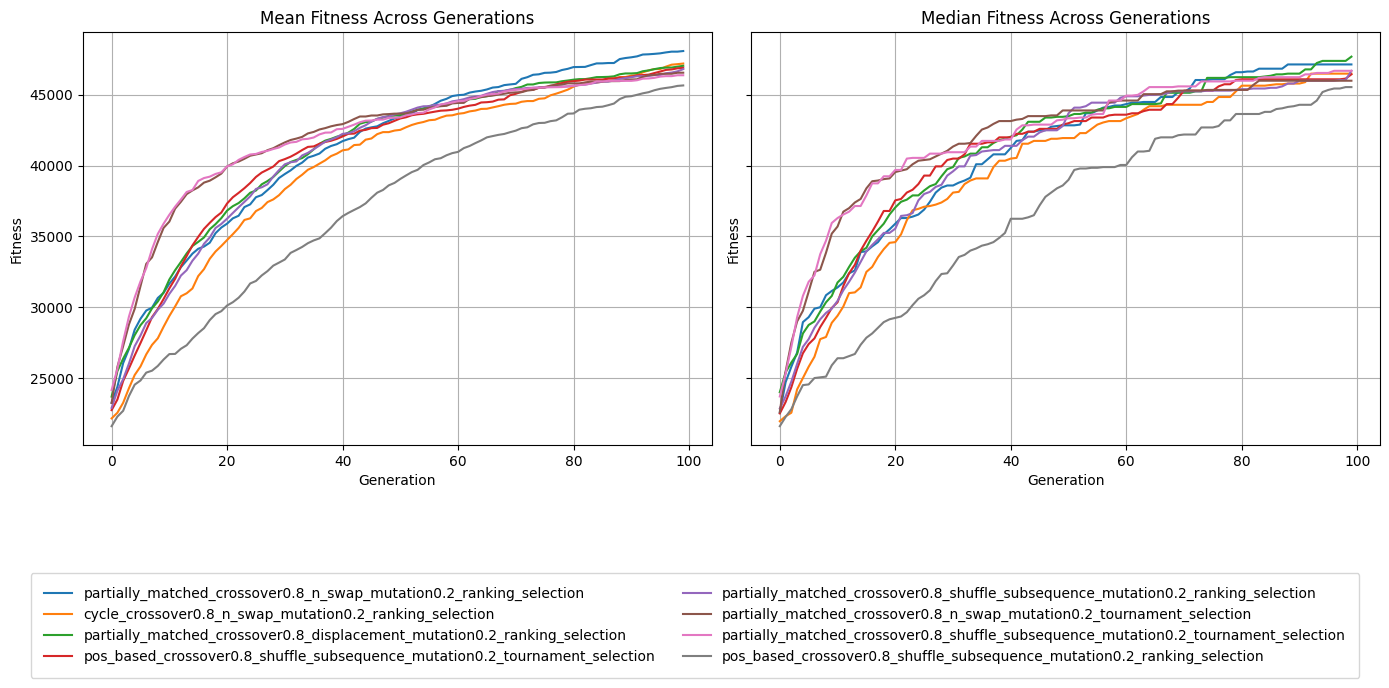

In [14]:
# Select the top 8 configurations with the highest mean fitness in the last generation
last_gen_fitness = {
    config: df[GENERATIONS - 1].mean() for config, df in fitness_dfs.items()
}

# Sort descending and take the top 8
top_configs = sorted(last_gen_fitness, key=last_gen_fitness.get, reverse=True)[:8]

print("Top 8 configurations sorted desc:")
for config in top_configs:
    print(f"{config}: {last_gen_fitness[config]}")

# Dictionary for plotting
top_fitness_dfs = {config: fitness_dfs[config] for config in top_configs}
plot_fitness_over_gen(top_fitness_dfs)

# Statistical Analysis of Phase 1 Results: ANOVA

To determine which congifuration we should carry on into the next phase of our experiment, we will conduct an ANOVA statistical test to determine which configuration, if any, has statistically significantly better results than the others.  


H_0: mean_1 = mean_2 = mean_3 = ... = mean_n (for i in range (0, n) where each mean_i is a configuration)  
H_a: at least one mean is different from the others  


Main idea of ANOVA: to test if variation of means BETWEEN groups is large compared to variation of means WITHIN groups. To do this, an ANOVA test compares the Mean Squared Error (MSE; weighted average of within-gropup variability) with the Mean Squared Treatments (MST; weighted average of between-group variability).  


The ANOVA test will calculate an F-statistic of F_s = MST/MSE.  
- If MST >> MSE, then F_s is big, we reject H_0, and there is a large difference in the means of the groups.
- On the contrary, if MST << MSE, then F_s is small, we fail to reject H_0, and there is not much difference between the means of the groups.  

This ANOVA test will simply indicate IF one of the means in the group is significantly different from the others. We will perform a post-hoc test to determine WHICH of the means it is.  


### ASSUMMPTIONS of ANOVA
- groups are independent (not sure about this one)
- observations are random samples (yes)
- group popualtion distributions are approximately normal (satisfied because n >= 30)
- group standard deviations are approximately equal (lets plot them)